In [1]:
### Importing libraries

import librosa

import IPython.display as ipd
import numpy as np
import scipy as sp
import math
import re
import os
import audioread
import soundfile as sf
import time

from signal import signal

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
df = pd.read_excel('dataset.xlsx')   # reading the dataset

In [3]:
removed_rows = df.iloc[:2, :]   # removing the first two rows 
df = df.iloc[2:, :]   # removing the first two rows
df = pd.concat([removed_rows, df], ignore_index=True)

In [4]:
 # list of speakers

speaker = ['anju', 'bharati', 'bibin', 'jeeva', 'kiru', 'madhavi', 'maheshaa', 'nandini',
           'shiva1', 'stephy', 'sunitha', 'triesa', 'venkatt', 'venktapa', 'vijje', 'vishal1'] 

In [5]:
# list of text
suffix = []
with open('allTrans.txt', 'r') as f:
    for line in f:
        data = line.split()         # strip any leading or trailing whitespace and append '.mp3' to the end of the string
        data = data[0] + '.mp3'     # Phoneme_L1_1-1 ,fast
        suffix.append(data)

print(data)

Sentence_L4_44.mp3


In [6]:
# list of audio file names for each speaker for each text
names = []

for line in suffix:
    for every in speaker:
        name = every + '_' + line
        names.append(name)
print(name)


vishal1_Sentence_L4_44.mp3


In [7]:
# check if the file exists in VoiceRecordings folder
# if it does, continue
# if it doesn't, remove the name from the list
for i in range(5):
    for name in names:
        if not os.path.exists('Voice recordings/' + name):
            names.remove(name)


In [8]:
# check if the file exists in VoiceRecordings folder
# if it does, print the name
# if it doesn't, print 'not found' and name
for name in names:
    if not os.path.exists('Voice recordings/' + name):
        print('not found', name)
    else:
        continue

print(names[7182])
names.remove(names[7182])
print(names[9758])
names.remove(names[9758])
print(names[9758])
names.remove(names[9758])
print(names[9758])
names.remove(names[9758])
print(names[14763])
names.remove(names[14763])
print(names[24813])
names.remove(names[24813])
print(names[24813])
names.remove(names[24813])


venktapa_Phoneme_L2_85-1.mp3
jeeva_Phoneme_L5_22-1.mp3
kiru_Phoneme_L5_22-1.mp3
madhavi_Phoneme_L5_22-1.mp3
bharati_Phoneme_L7_27-2.mp3
nandini_Sentence_L3_37.mp3
stephy_Sentence_L3_37.mp3


In [9]:
# for every name in the list, open the file and read the audio to check if it's a valid audio file
audio = []

for name in names:
    file_path = os.path.join('Voice recordings/', name)
    if name.endswith(".mp3"):  # or any other audio file format you want to load
        with audioread.audio_open(file_path) as audio_file:
            # read audio samples with soundfile library
            samples, sample_rate = sf.read(file_path, dtype='float32')

In [10]:
data_list = df[['stimuli', 'Ques1']].values.tolist()
for line in data_list:
    red = line[0].split('_')
    extend = red[3].lstrip('0')
    line[0] = red[0] + '_' + red[1] + '_' + red[2] + '_' + extend + '.mp3'

# check if the file exists in names list
# if it does, continue
# if it doesn't, remove the name from the list
for line in data_list:
    if line[0] not in names:
        data_list.remove(line)


In [11]:
# Get the indices of the reference_list elements in the data_list
indices = [names.index(x[0]) for x in data_list]

# Reorder the data_list based on the indices
intelligibility = [data_list[i] for i in sorted(
    range(len(data_list)), key=lambda k: indices[k])]


for each name how many speakers are there

In [12]:
# split intelligibility list column iusing '_' and remove leading zeros
group = []

for line in intelligibility:
    red = line[0].split('_')
    extend = red[3]
    group.append(extend)

# add the group column to the intelligibility list
# append the group column to the start of the list
for i in range(len(intelligibility)):
    intelligibility[i].insert(0, group[i])


In [13]:
groups = []
start = 0

for i in range(1, len(intelligibility)):
    if intelligibility[i][0] != intelligibility[i-1][0]:
        groups.append([x[1:] for x in intelligibility[start:i]])
        start = i
groups.append([x[1:] for x in intelligibility[start:]])


In [14]:
intel = []
intel_non = []

for line in groups:
    intelligible = []
    intelligible_non = []
    for i in range(len(line)):
        if line[i][1] == 0:
            intelligible.append(line[i][0])
        else:
            intelligible_non.append(line[i][0])
    intel.append(intelligible)
    intel_non.append(intelligible_non)


In [15]:
def kl_divergence_sym(p, q):
    return 1/2*(kl_divergence(p, q) + kl_divergence(q, p))

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(abs(p / q)), 0))

def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0

    for i in range(1, n):
        for j in range(1, m):
            cost = kl_divergence_sym(s[i-1], t[j-1])
            # take last min from a square box
            last_min = np.min(
                [dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix[n-1, m-1]

In [16]:
scores = []

for line in intel[:200]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print("--- %s seconds ---" % (time.time()))
    print(tyre)
    
os.system('say "your program has finished pew pew pew pew pew pew pew pew pew pew pew"')

--- 1679942786.507947 seconds ---
[-4841.636151313782, -4546.276042699814, -7310.871335983276, -12551.948001861572, -4115.435203552246, -2370.4818115234375, -2597.359798192978, -6249.498741149902, -4892.527131557465, -3775.515239715576, -2838.5663990974426, -3977.716486930847, -4397.072805404663, -10392.641510009766, -16011.6263256073, -29796.78389263153, -11128.99377822876, -6605.505420684814, -4166.960876464844, -14467.527992248535, -8608.052874326706, -4964.819978713989, -6703.114667892456, -6453.822439193726, -12490.668003082275, -9987.563245773315, -15276.777778625488, -5062.851268768311, -2487.054980278015, -5723.082445144653, -7591.221830368042, -8377.344601154327, -7958.541454315186, -4356.904449462891, -6821.17200088501, -6748.591758728027, -25878.839420318604, -11856.066413879395, -7726.320711135864, -8753.319965362549, -17345.336265563965, -10984.343541145325, -11863.48454284668, -7831.89172077179, -10369.512575149536, -12997.183338165283, -11002.374599456787, -5814.42107963

0

In [17]:
for line in intel[200:400]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print(tyre)

os.system('say "your program has finished pew pew pew pew pew pew pew pew pew pew pew"')

[-15548.737508535385, -7320.80438709259, -19456.446590423584, -23870.39808654785, -17373.269269943237, -37666.67353439331]
[-6825.276025772095, -4864.111201286316, -9996.85313987732, -5030.413956642151, -2896.4359397888184, -4427.590166091919, -4705.0078411102295, -8941.596393108368, -6618.969641685486, -6146.844680786133, -7817.792377471924, -6649.002513408661, -9055.777936458588, -9749.473642349243, -5656.857036590576, -12204.842851638794, -5574.894383192062, -3986.1366863250732, -3579.396119117737, -6254.501426696777, -9310.982814788818, -7652.660891532898, -13156.050749778748, -7963.528124809265, -8854.800889968872, -9929.069097995758, -15015.257284164429, -9938.757034301758, -4118.275012016296, -2692.570686340332, -4154.6966552734375, -5089.203840255737, -7658.559770584106, -6297.069603919983, -5415.150794744492, -7798.522828102112, -5224.396537780762, -7751.4518184661865, -9406.774131774902, -5911.751655578613, -9530.326332092285, -7127.56436920166, -5712.103933334351, -8929.1716

0

In [18]:
print(scores[1])

[-12290.713869094849, -3951.8421878814697, -7040.738388061523, -10650.368766784668, -3402.0190982818604, -3196.15838432312, -3010.3159580230713, -3637.6491146087646, -3941.639856338501, -3102.373443841934, -21646.828674316406, -4526.182022094727, -4759.124908447266, -11541.384267807007, -6468.711894989014, -9112.911354064941, -14683.16166305542, -13364.112800598145, -7735.4262590408325, -15448.268798828125, -6055.089673995972, -12870.352550506592, -19624.183311462402, -7723.804397583008, -15902.584001541138, -7334.483047485352, -11761.808403015137, -3881.592544555664, -4330.979766845703, -4186.229717254639, -3244.7753677368164, -4611.60276222229, -2962.305145263672, -22290.7915725708, -5148.2845458984375, -5229.562512397766, -3709.714268684387, -8689.90909576416, -8746.78034210205, -5202.583656311035, -9843.153411865234, -4512.857805252075, -6549.115001678467, -7291.653720855713, -3994.760358810425, -10176.087215423584, -14485.502258300781, -13884.529151916504, -6978.736095428467, -158

In [19]:
for line in intel[400:600]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print(tyre)

os.system('say "your program has finished pew pew pew pew pew pew pew pew pew pew pew"')


[-5185.628782272339, -13443.301785469055, -18391.6952419281, -1984.2282390594482, -3259.009916305542, -15262.42059135437, -14631.680358886719, -6957.518516540527, -2296.1279191970825, -3085.152214050293, -5881.648640632629, -5365.670120239258, -15159.496046066284, -31731.581401109695, -42405.631366729736, -4256.755800247192, -7206.541603088379, -28074.119333267212, -41413.933238983154, -11695.734996795654, -5171.406120300293, -7628.910930633545, -16611.510557174683, -9973.434509277344, -30586.27967262268, -16483.026859521866, -6932.723930358887, -1185.5263080596924, -10083.692370414734, -31639.843353271484, -37762.22957229614, -18204.22373008728, -8804.805198669434, -35622.55925941467, -22632.09686088562, -11270.019922971725, -5571.896926879883, -6860.881317615509, -18714.706422805786, -35909.94031882286, -44415.33846092224, -20556.36019897461, -12405.565831184387, -42587.03617858887, -26456.54002761841, -19930.049783706665, -3180.124038696289, -8970.054969787598, -4378.355722427368, -

0

In [20]:
for line in intel[600:800]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print(tyre)

[-10035.166007995605, -6516.940047264099, -12139.849681854248, -13293.229080200195, -13317.360095977783, -3660.1042985916138, -7684.001235961914, -6144.948135375977, -9614.572448730469, -5659.417934417725, -5480.717403411865, -11514.758571624756, -5652.547510147095, -7150.821489334106, -8748.12377357483, -15151.25841140747, -15174.496969223022, -16042.439701080322, -5968.1685218811035, -8975.188705444336, -9029.406663894653, -11119.210109710693, -7458.529630661011, -7496.405406951904, -14351.495826721191, -7605.687824249268, -10959.356288909912, -10200.88325881958, -10405.24492073059, -10725.944471359253, -2655.802499771118, -7946.919229507446, -6622.79256439209, -11208.986949920654, -8135.639561653137, -7551.525001525879, -9961.299936294556, -5692.047137260437, -10479.550256729126, -8322.420718669891, -10577.547077178955, -4113.340658187866, -5674.168748378754, -14666.360111236572, -18461.617500305176, -17277.67266845703, -14374.76262664795, -7809.109977245331, -12408.823053359985, -2

0

In [21]:
for line in intel[800:1000]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print("--- %s seconds ---" % (time.time()))
    print(tyre)

--- 1679945979.731893 seconds ---
[-10376.84617805481, -6227.707104682922, -7827.676700592041, -5302.177604675293, -6237.795690536499, -9863.41897201538, -9083.97378540039, -7605.282974243164, -6542.643936157227, -6747.213807106018, -19312.84870147705, -8759.694841384888, -8401.482208251953, -7719.182651519775, -9585.176284790039, -13998.366161346436, -10470.315971374512, -7959.5285539627075, -10213.25663948059, -19807.4881401062, -14565.03572845459, -11524.485557556152, -11706.222492218018, -19488.011964797974, -11335.219386100769, -11224.209823608398, -14934.727989196777, -8560.005090713501, -6118.733936309814, -6791.701694488525, -9150.864528656006, -9847.564636230469, -7969.1263217926025, -6246.576002120972, -7186.000120162964, -19368.3875541687, -8987.670324325562, -8721.06914138794, -8163.135766983032, -8895.445659637451, -9267.873165130615, -12264.429546356201, -10864.443385124207, -9518.978011131287, -8729.321311950684, -9237.458526611328, -22071.101115226746, -11270.8972244262

In [22]:
for line in intel[1000:1100]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print(tyre)

[-11226.236426830292, -14188.030527114868, -10708.194288253784, -8672.999147415161, -12790.03130531311, -8343.757355690002, -13486.791847229004, -10087.834594726562, -15348.59337568283, -16900.03995513916, -8578.128556728363, -23080.18101501465, -14415.008125305176, -25990.237022399902, -19642.14895248413, -20652.6805267334, -7010.489372253418, -20278.857334136963, -14808.121463775635, -6923.343444824219, -9248.129270076752, -24126.060138702393, -6656.910913467407, -15845.070297241211, -10732.757396697998, -4841.7239112854, -24368.872135162354, -19110.379371643066, -14927.001472473145, -18753.27972984314, -15090.689252853394, -22096.20011138916, -16259.206045150757, -28026.431898117065, -24774.56177520752, -15185.974609375, -31279.50454711914, -22635.68090057373, -32118.316207885742, -16620.56573009491, -16502.42060470581, -13967.211802005768, -20914.488571166992, -16264.46660232544, -19814.662025928497, -29579.688131332397, -12305.69039106369, -36243.12169408798, -25189.869621276855, 

In [23]:
for line in intel[1100:1200]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print(tyre)

[-20141.767292022705, -23001.46630382538, -23031.880624771118, -17305.78286743164, -8394.704301834106, -9155.831803798676, -22008.36065864563, -27641.258420944214, -33428.755825042725, -26532.15668487549, -23101.99608039856, -25599.393319129944, -7801.014423370361, -9291.003584861755, -7588.818531036377, -10623.055755615234, -27137.99521636963, -13643.629678726196, -10491.281251907349, -20694.75408267975, -18118.592253684998, -7485.829250335693, -10808.016833305359, -24144.763671875, -26985.333256721497, -35420.98875808716, -28081.45700931549, -16667.05833339691, -3865.068016052246, -11882.60650062561, -26499.04048204422, -24288.603370666504, -42773.584648132324, -32017.94993019104, -8453.77043914795, -5362.845209121704, -7536.483003616333, -16645.235487937927, -11384.313599586487, -7713.374171257019, -1471.411060333252, -9787.964332580566, -7019.736440658569, -16723.28197669983, -12922.594970703125, -8636.571156859398, -13895.175518035889, -13734.557525634766, -9895.45652103424, -2732

In [24]:
for line in intel[1200:1300]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print(tyre)

[-15307.968391418457, -17172.15795326233, -19201.12757396698, -15629.696323394775, -12443.7523727417, -18261.65080833435, -6325.259372711182, -16669.743885040283, -16900.77331161499, -18250.178428649902, -14114.115371704102, -20334.67236185074, -33006.302726745605, -19878.37322998047, -17533.427562713623, -12106.704284667969, -23669.47752046585, -25961.880430221558, -10120.574444055557, -24410.963424682617, -9236.271758079529, -30773.662837982178, -13143.868309020996, -9920.030912399292, -10369.94169807434, -24497.55908203125, -20624.248207092285, -14279.263252735138, -15900.391446113586, -27161.584087371826, -29227.720260620117, -10729.782382011414, -29786.197074890137, -12099.80443572998, -35442.70233917236, -14625.331733703613, -9102.095956802368, -10199.506423950195, -32122.387355804443, -12534.286121368408, -13447.18325996399, -12598.853531837463, -28325.108825683594, -17740.994665145874, -32448.579189300537, -12924.759983062744, -36580.99572944641, -22233.462531089783, -25824.258

In [25]:
print(len(scores))

1300


In [26]:
for line in intel[1300:1400]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print(tyre)

[-9027.486253738403, -9677.067991256714, -12383.10916185379, -17364.637682437897, -13178.028409957886, -4699.552953720093, -4097.425132751465, -9784.794345855713, -11452.415380477905, -9216.615022659302, -10527.741736412048, -10832.036289215088, -13819.425436019897, -7196.19423365593, -36809.720079422, -12386.157717704773, -19333.51561164856, -32326.192947387695, -23743.202226638794, -8871.197690963745, -8765.443832397461, -12198.422653198242, -14273.504940032959, -11352.706302642822, -12441.15071105957, -18084.245609283447, -17564.244287490845, -10150.632556915283, -67681.14942932129, -22232.989117622375, -39770.84763336182, -27928.705373764038, -8474.695360183716, -10114.471461296082, -11898.481164932251, -14980.492454528809, -11593.636350154877, -13362.180770874023, -23925.090309143066, -18510.340475082397, -10881.875690460205, -83443.72968101501, -41350.72150802612, -37017.76740837097, -10638.351558685303, -12690.414243876934, -23921.3860912323, -27223.582710266113, -21493.54170227

In [27]:
print(len(scores))

1400


In [28]:
for line in intel[1400:1500]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print(tyre)

[-19989.674787521362, -14913.450771331787, -23126.994220733643, -14961.740802764893, -14518.610342025757, -10249.89336013794, -7908.657754898071, -8537.475120544434, -12295.326168060303, -13440.356060028076, -16288.711883544922, -21339.236488342285, -12792.126829147339, -34069.16372680664, -31245.0887260437, -47303.491399765015, -30114.152179718018, -30550.91512298584, -21274.2466878891, -19967.971279144287, -21365.259141921997, -24477.274990081787, -28279.215213775635, -28274.648906707764, -39471.20697784424, -23420.631927490234, -61628.18159198761, -39826.76152133942, -14884.394664764404, -19671.148624420166, -21487.097646713257, -15829.664226531982, -10742.53066444397, -16388.125802993774, -17410.281354904175, -21577.19148826599, -25197.86682510376, -16743.109344482422, -39683.87140274048, -37514.00843811035, -34816.00780391693, -25684.695037841797, -27078.99492931366, -27478.2194108963, -36580.55369377136, -39577.57462501526, -37784.83204078674, -50849.95198440552, -32115.047527313

In [29]:
print(len(scores))

1500


In [30]:
for line in intel[1500:1600]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print(tyre)

[-32651.483837127686, -61275.43342971802, -55491.47495651245, -33187.673080444336, -41395.71883773804, -38629.41046333313, -29490.509818077087, -21711.521768569946, -55613.0478553772, -43096.04580307007, -39891.73319244385, -60752.769287109375, -47388.75899505615, -60707.22219657898, -57621.763441085815, -52509.70891618729, -33483.23583698273, -36398.5835647583, -45565.97712135315, -33757.22841691971, -19861.38297176361, -48564.983196258545, -38003.71994018555, -37470.88520884514, -53248.55027008057, -44113.29846382141, -65078.02955818176, -69489.54160785675, -37443.135272979736, -39576.78462791443, -91933.24461555481, -75391.22875785828, -30235.238563537598, -53120.2604598999, -38009.62745189667, -44826.15543174744, -39108.08802032471, -37139.10428619385, -87128.09225177765, -45889.95983791351, -52695.36268615723, -86027.07899665833, -67159.5042886734, -30217.700412750244, -62225.87594127655, -52890.23749542236, -53452.55729484558, -60375.24309158325, -56522.96396446228, -98728.374774

In [31]:
print(len(scores))

1600


In [32]:
for line in intel[1600:1676]:
    tyre = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre.append(ddttww)
    scores.append(tyre)
    print(tyre)

[-48491.69097280502, -53465.211252212524, -56049.527228832245, -50819.898012161255, -28946.156839370728, -27279.13945913315, -60444.56076526642, -48453.26587677002, -41792.4262676239, -35460.547468185425, -82499.43665885925, -77462.65304255486, -61920.21939134598, -55585.344913482666, -70718.64003753662, -58323.92536354065, -24001.58888721466, -25784.186402082443, -81362.95194625854, -52762.009408950806, -44221.19920349121, -30111.509465694427, -94626.71220397949, -91759.23526000977, -70489.9086265564, -47388.9702167511, -46803.57652401924, -37325.21644973755, -32374.46133995056, -52675.847385406494, -54195.829954624176, -40845.90539741516, -41165.26911354065, -64421.63848686218, -61547.08470916748, -49392.50599813461, -44874.348278045654, -50187.23738861084, -41932.38816070557, -45654.30601024628, -54689.18884849548, -36221.035309791565, -44671.43137931824, -55122.35612487793, -55280.31615924835, -50375.220620155334, -39356.347831726074, -34672.72971916199, -36646.76122570038, -53270.

In [33]:
print(len(scores))

1668


1668
-9489.349034309387
-7329.592008590698
-9804.480327606201
-9127.782947540283
-7259.372027397156
-5656.844820022583
-11681.455665588379
-11052.45030593872
-11415.857913970947
-15645.509292602539
-2788.927391052246
-2158.109706878662
-6916.39374256134
-4194.863975524902
-6682.929599761963
-9541.88231086731
-11750.004318237305
-9251.259002685547
-8458.296007156372
-5966.433482170105
-8080.219207763672
-6533.53804397583
-35843.66489601135
-4528.014064788818
-4288.158639907837
-8728.141025543213
-4634.433908462524
-3924.0596561431885
-7402.174957275391
-7746.426730871201
-2939.849281311035
-15372.008213043213
-8736.714206695557
-7839.7737827301025
-6602.974682807922
-1713.2714686393738
-8957.87471294403
-8922.75705909729
-3892.5579147338867
-4380.285205841064
-7247.602596282959
-5420.790111541748
-6524.071018218994
-4650.9804973602295
-8824.534191131592
-8626.041456222534
-3098.839245557785
-2163.1537914276123
-6575.1642055511475
-5754.722537994385
-7348.140048980713
-12913.654304504395

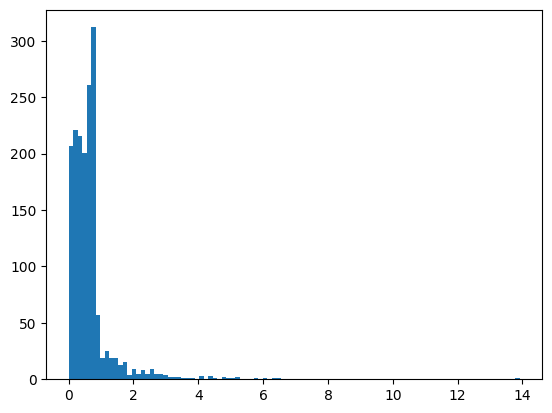

In [34]:
# take the last element of each row and make anew list

from sklearn.preprocessing import StandardScaler
histo = []
scores = np.array(scores)
print(len(scores))
for i in range(len(scores)):
    if len(scores[i]) == 0:
        continue
    print(scores[i][len(scores[i])-1])
    histo.append(scores[i][len(scores[i])-1])
    
histo = np.array(histo)

scaler = StandardScaler()
normalized_array = scaler.fit_transform(histo.reshape(-1, 1))

# Take the absolute value of all elements in the normalized array
abs_array = np.abs(normalized_array)


plt.hist(abs_array, bins=100)

# Display the plot
plt.show()
# convert 

In [35]:
scores1 = []

for line in intel_non:
    tyre1 = []
    for i in range(len(line)):
        if isinstance(line[i], str):
                file_path = os.path.join('Voice recordings', line[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue  # skip over NaN values
        mfccs = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        for j in range(i+1, len(line)):
            if isinstance(line[j], str):
                file_path = os.path.join('Voice recordings', line[j])
                test, test_rate = sf.read(file_path, dtype='float32')
            else:
                continue
            mfccs2 = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
            ddttww = dtw(mfccs.T, mfccs2.T)
            tyre1.append(ddttww)
    scores1.append(tyre1)
    print(tyre1)

[-10842.456150054932]
[]
[]
[-7514.942714691162, -4805.42897605896, -2745.661745071411, -2632.244194984436, -2100.10076713562, -5922.303428649902, -3660.6534461975098, -2602.023536682129, -11745.409442901611, -8295.436824321747, -9197.85668182373, -4064.6965551376343, -10291.503170013428, -10188.782152175903, -4957.5809688568115, -4877.153935432434, -6081.463645935059, -3721.9115257263184, -9034.017990112305, -6214.826365470886, -5500.190790176392, -2703.2955951690674, -2247.622964859009, -7623.474805831909, -3700.2996683120728, -3364.915512084961, -3876.2792205810547, -7953.619707107544, -2853.1844596862793, -5685.288520812988, -3809.8215732574463, -3164.2260398864746, -2468.333299636841, -8795.312992095947, -4067.185661315918, -5054.543651580811]
[-17325.32173538208, -23693.180109024048, -6152.76895904541, -26747.4376745224, -5403.7236404418945, -7454.129829406738, -30040.538078308105, -13245.444847106934, -31289.371154785156, -12719.407649993896, -19269.98808670044, -14061.125499725

1
0
0
36
21
21
6
0
1
0
0
0
0
36
0
15
0
0
3
1
0
0
78
0
0
0
0
0
3
0
0
3
21
15
0
66
1
0
6
0
0
3
3
45
15
10
10
0
1
0
0
15
36
3
21
10
3
0
1
3
1
1
15
1
0
0
0
6
0
0
0
0
0
0
0
6
0
0
3
3
3
1
3
0
0
15
0
1
0
0
0
0
10
1
0
0
1
15
0
0
1
0
0
10
0
0
6
0
0
45
28
1
0
0
55
1
45
0
0
0
6
0
0
21
3
0
0
10
0
0
0
1
1
55
6
1
0
91
3
0
0
21
55
0
28
15
0
3
6
45
55
10
15
0
0
6
0
0
66
28
0
6
10
91
15
0
0
36
36
10
0
0
0
0
0
0
0
10
0
0
0
0
1
0
0
36
0
0
0
0
0
0
0
0
1
0
15
0
6
0
55
0
10
0
0
0
36
0
0
0
3
6
1
0
1
0
0
0
0
1
0
3
1
1
0
55
0
1
0
0
36
0
6
0
10
10
6
3
1
1
0
0
0
0
0
45
6
0
0
21
6
10
91
3
36
0
6
3
66
3
0
0
0
0
0
0
0
0
0
0
0
0
1
0
3
0
3
1
0
0
3
0
6
1
0
0
1
3
0
1
1
0
1
0
0
0
0
0
1
0
36
0
0
0
1
21
0
15
0
0
78
0
0
0
0
0
0
10
0
10
0
0
0
0
0
0
1
0
1
0
36
0
0
0
1
0
0
0
0
15
3
6
0
0
0
0
10
55
0
0
3
1
6
0
0
1
0
0
6
0
0
105
0
21
28
0
0
0
0
1
15
3
0
0
0
10
78
0
55
0
0
0
3
3
0
1
0
3
0
1
1
0
0
1
0
0
0
0
1
0
1
0
0
0
1
0
1
0
0
1
0
3
15
10
0
1
0
6
0
0
0
0
0
15
1
0
0
0
1
28
0
28
21
28
0
3
0
6
0
0
0
1
0
15
1
0
0
1
0
10
0
1
0
15
0


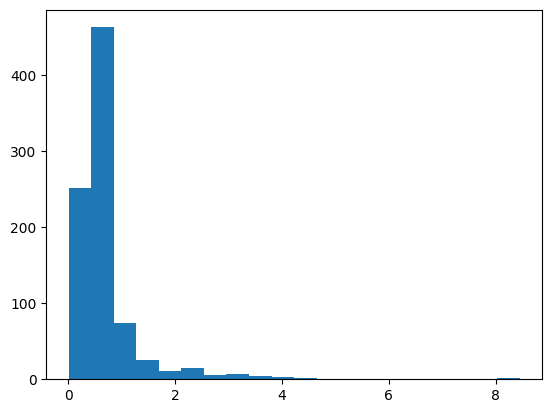

In [36]:
from sklearn.preprocessing import StandardScaler
histo1 = []
scores1 = np.array(scores1)
for i in range(len(scores1)):
    print(len(scores1[i]))
    if len(scores1[i]) == 1:
        histo1.append(scores1[i][0])
    if len(scores1[i]) == 0:
        continue
    else:
        histo1.append(scores1[i][len(scores1[i])-1]) 



histo1 = np.array(histo1)

scaler = StandardScaler()
normalized_array = scaler.fit_transform(histo1.reshape(-1, 1))

# Take the absolute value of all elements in the normalized array
abs_array = np.abs(normalized_array)


plt.hist(abs_array, bins=20)

# Display the plot
plt.show()
# convert 

In [37]:
cross = []

for i in range(len(intel)):
    first = intel[i]
    second = intel_non[i]
    tyre_cross = []
    for i in range(len(first)):
        if isinstance(first[i], str):
                file_path = os.path.join('Voice recordings', first[i])
                control, control_rate = sf.read(file_path, dtype='float32')
        else:
            continue
        mfccs_cross = librosa.feature.mfcc(control, n_mfcc=13, sr=control_rate)
        if len(second) != 0:
            for j in range(len(second)):
                if isinstance(second[j], str):
                    file_path = os.path.join('Voice recordings', second[j])
                    test, test_rate = sf.read(file_path, dtype='float32')
                else:
                    continue
                cross_mfccs = librosa.feature.mfcc(test, n_mfcc=13, sr=test_rate)
                ddttww_Cross = dtw(mfccs_cross.T, cross_mfccs.T)
                tyre_cross.append(ddttww_Cross)
        else:
            tyre_cross.append(0)
    cross.append(tyre_cross)
    print(tyre_cross)
        

[-18096.466541290283, -7272.894493103027, -24268.64666366577, -10559.717058181763, -26447.324466705322, -12375.935173034668, -38453.24782657623, -18316.73801612854, -69114.20293426514, -35734.56926822662, -36306.11701583862, -17461.76252937317, -24746.408250808716, -11430.205387115479, -16083.747482299805, -7077.067245483398, -40933.797843933105, -20053.150352478027, -21013.61318206787, -8411.228174209595, -12132.251665115356, -5243.607433319092, -26293.52899169922, -10636.013200759888, -15023.263772010803, -5921.400100708008, -35278.77778625488, -16706.236221313477]
[-6607.160511016846, -6282.126783370972, -6347.423444747925, -2600.0954179763794, -4229.239404678345, -8336.863327026367, -9052.198448181152, -4926.491329193115, -9101.459342956543, -4345.540336608887, -5706.903583526611, -8047.340026855469, -3827.5630736351013, -9844.412525177002]
[-3164.096935272217, -10502.372511863708, -8666.021879196167, -7909.290502309799, -4374.164467573166, -2068.6972465515137, -4011.973985671997, 

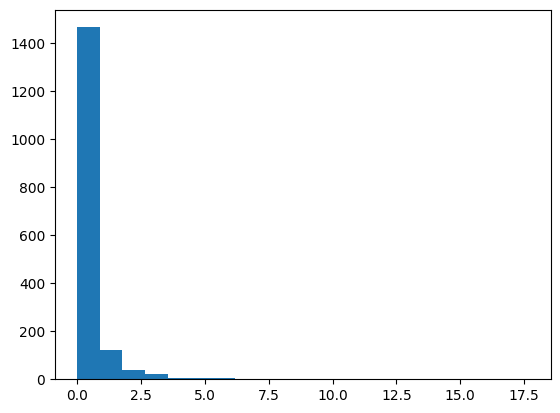

In [38]:
from sklearn.preprocessing import StandardScaler
histo_cross = []
scores_cross = np.array(cross)
for i in range(len(scores_cross)):
    if len(scores_cross[i]) == 1:
        histo_cross.append(scores_cross[i][0])
    if len(scores_cross[i]) == 0:
        continue
    else:
        histo_cross.append(scores_cross[i][len(scores_cross[i])-1])
        
histo_cross = np.array(histo_cross)


scaler = StandardScaler()
normalized_array = scaler.fit_transform(histo_cross.reshape(-1, 1))

# Take the absolute value of all elements in the normalized array
abs_array = np.abs(normalized_array)


plt.hist(abs_array, bins=20)

# Display the plot
plt.show()
# convert 